# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [3]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import cv2

%matplotlib inline

In [ ]:
dataset = get_dataset("home/workspace/data/train/*.tfrecord")

## Function to display an image and the bounding boxes

`display_instances` function takes a batch as an input and display an image with its corresponding bounding boxes. The classes are should be color coded (vehicles in red, pedestrians in blue, cyclist in green).

In [62]:
def display_images(batch):
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    myit = iter(batch) #iterator variable for batch
    f, ax = plt.subplots(4, 5, figsize=(20, 10))
    
    for i in range(20):
        x = i % 4
        y = i % 5
        instance = next(myit)
        
        filename = instance['filename']
        img = instance['image']
        
        img_shape = img.shape
        ax[x, y].imshow(img)

        bboxes = instance['groundtruth_boxes']
        bboxes_resized = np.transpose([bboxes[:, 0] * img_shape[0], bboxes[:, 1] * img_shape[1], bboxes[:, 2] * img_shape[0], bboxes[:, 3] * img_shape[1]])
        
        classes = instance['groundtruth_classes']
        css = classes.numpy() #convert classes vaiable to numpy array
        
        for cl, bb in zip(css, bboxes_resized):
            y1, x1, y2, x2 = bb
            rec = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=colormap[cl], facecolor='none')
            ax[x, y].add_patch(rec)
        ax[x ,y].axis('off')
    plt.tight_layout()
    plt.show()


    
    

## Display 20 images 

Display 20 random images with the associated bounding boxes.

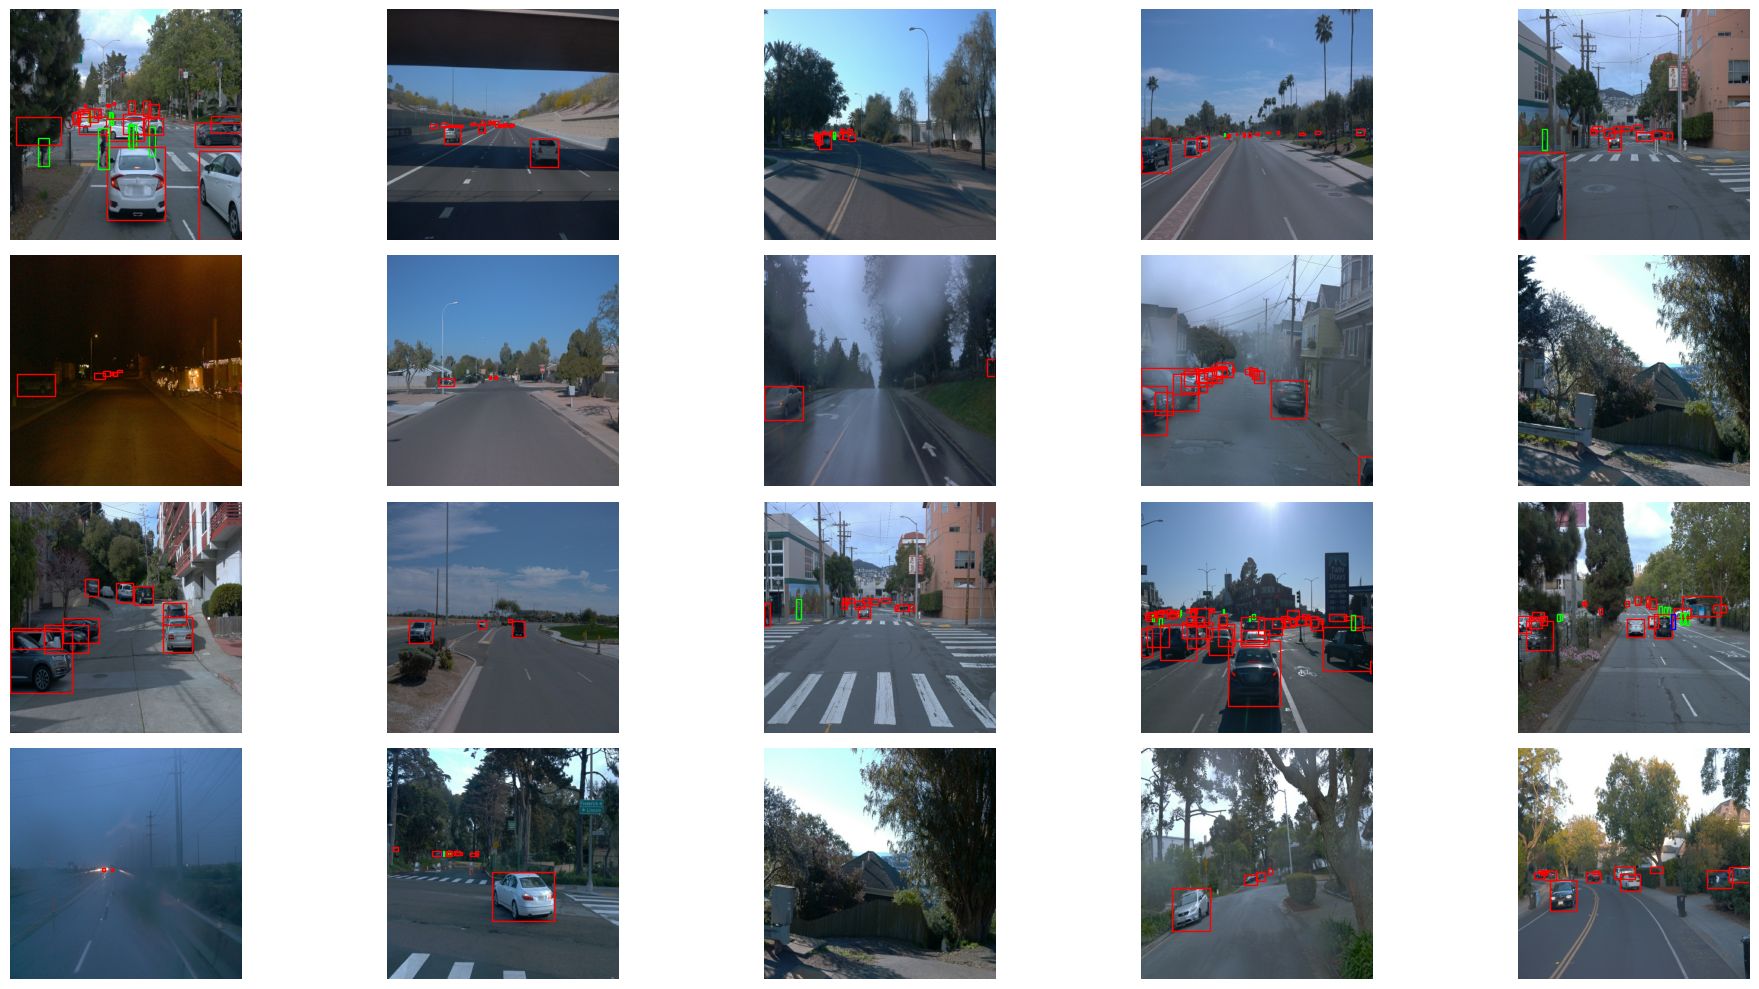

In [63]:
## STUDENT SOLUTION HERE
dataset.shuffle(5)
batch = dataset.take(20)

display_images(batch)

## Additional EDA

Two additional EDA are performed
- Distribution of classes
- Distribution of bright and dim (can be interpeted as Day vs Night) images


### Distribution of Classes

In [46]:
batch = dataset.take(10000)
count_cars = 0
count_pedestrains = 0
count_cyclist = 0
for instance in batch:
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    
    classes = instance['groundtruth_classes']
    css = classes.numpy()
    unique, counts = np.unique(css, return_counts=True)
    a = dict(zip(unique, counts))
      
    if 1 in a.keys():
        count_cars += a[1]
    
    if 2 in a.keys():
        count_pedestrains += a[2]
    
    if 4 in a.keys():
        count_cyclist += a[4]
classes_names = ["cars","pedestrains","cyclist"]
count = [count_cars , count_pedestrains,count_cyclist ]



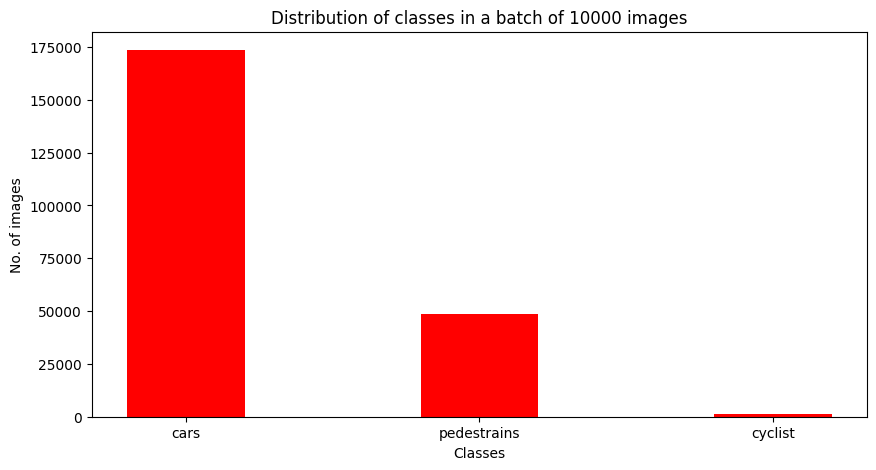

No of cars in the batch: 173561
No of pedestrians in the batch: 48563
No of cyclist in the batch 1257


In [47]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes_names, count, color ='red',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.title("Distribution of classes in a batch of 10000 images")
plt.show()
print("No of cars in the batch:",count_cars)
print("No of pedestrians in the batch:",count_pedestrains)
print("No of cyclist in the batch",count_cyclist)

### Bight vs Dim images (Day vs Night)

#### Fininding the threshold by exploring the dataset 
Inspiration from  https://github.com/arunnthevapalan/day-night-classifier/blob/master/classifier.ipynb

In [97]:
def display_images_for_treshold(batch,threshold):
#print(""batch)
#print(instance)    
    myit = iter(batch)     
    f, ax = plt.subplots(4, 5, figsize=(20, 10))
    i = 0
    for a in range(500):
        
        instance = next(myit)
        img = instance['image']        
        img_shape = img.shape
        
        img1 = img.numpy()
        hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)

        # Add up all the pixel values in the V channel
        sum_brightness = np.sum(hsv[:,:,2])
        area = img_shape[0]*img_shape[1]  # pixels

        # find the avg
        avg = float(sum_brightness)/area
        
        if(avg<threshold):            
            x = i % 4
            y = i % 5
            ax[x, y].imshow(img)
            ax[x ,y].axis('off')
            i = i+1
            if(i==20):
                break
            
    
    plt.tight_layout()
#     f.subplots_adjust(hspace=0.6, top=0.85)
#     f.suptitle("Dim(or Night) Images",fontsize=30)
    plt.show()
    

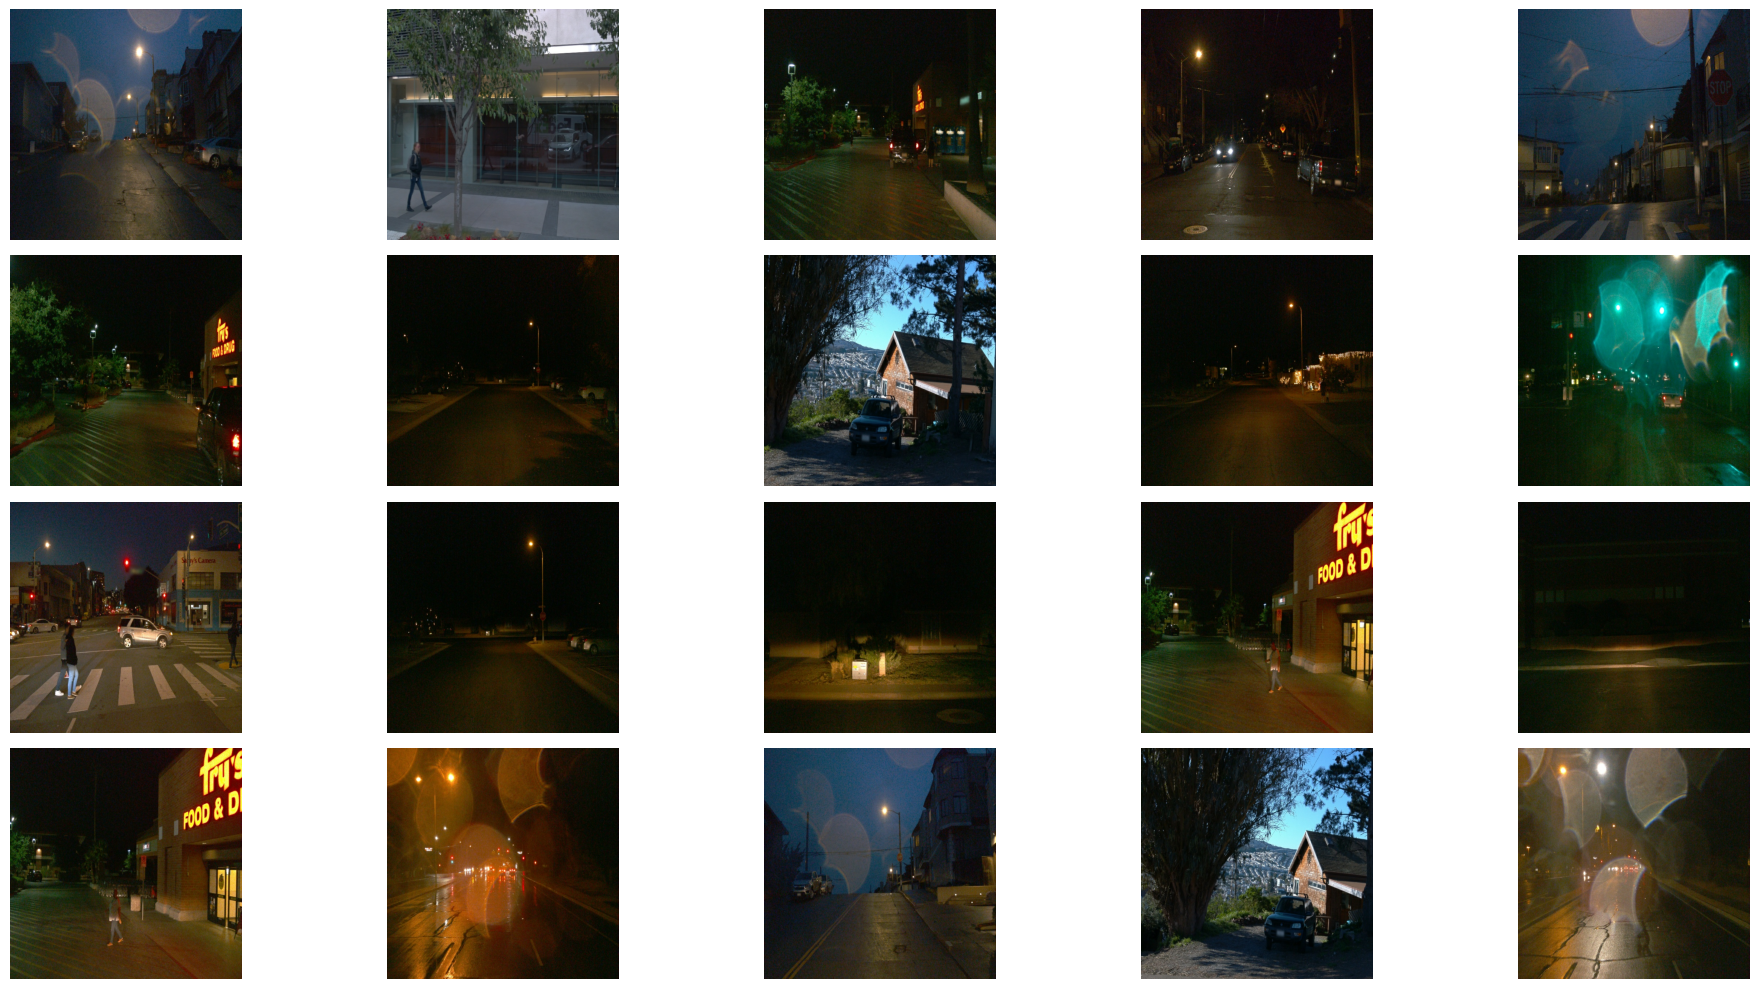

In [98]:
dataset.shuffle(5)
batch = dataset.take(500)
threshold = 80
display_images_for_treshold(batch,80)

#### Plotting the distribution for threshold 

In [64]:
#threshold found by exploring the dataset was 80
threshold = 80

In [77]:
batch = dataset.take(10000)
night = 0
day = 0
count_cyclist = 0
for instance in batch:
        
    img = instance['image']
    img_shape = img.shape
    
    img1 = img.numpy()
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    
    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = img_shape[0]*img_shape[1]  # pixels

    # find the avg
    avg = float(sum_brightness)/area
    
    if(avg<threshold):
        night +=1
    else:
        day +=1


Bright images: 8995
Dim images: 1005


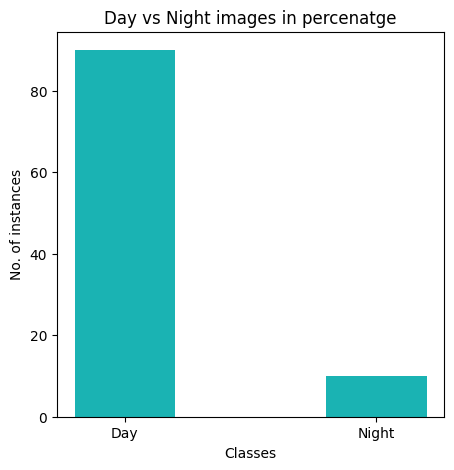

In [79]:
print("Bright images:",day)
print("Dim images:",night)
x_axis = ["Day","Night"]
percentage = [day/10000*100 , night/10000*100 ]

fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(x_axis, percentage, color =(0.1,0.7,0.7),
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of instances")
plt.title("Day vs Night images in percenatge")
plt.show()